# SQL Alchemy - Surfs Up!

In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
#Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [66]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [7]:
#get column details for the tables
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [8]:
#column details for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [74]:
#view measurment table content
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
#column details for station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [72]:
#view station table content
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Last Date
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23')

In [11]:
#1 year from last date
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("A Year from last date: ", year_ago)

A Year from last date:  2016-08-23


In [35]:
# Perform a query to retrieve the data and precipitation scores
precpi_score = session.query(measurement.date, measurement.prcp).filter\
    (measurement.date >= year_ago).all()
preci_df = pd.DataFrame(precpi_score, columns=["Date", "Precipitation"])
preci_df.set_index(["Date"], inplace=True)
preci_df = preci_df.sort_index()
preci_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [44]:
# Use Pandas Plotting with Matplotlib to plot the data
preci_df.sort_index().preci_df.plot(title="Precipitatio Analysis", rot=90, xlabel="Date",
              ylabel="Inches", legend='best')
plt.savefig("Images/Precipitatio.png")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'preci_df'

<AxesSubplot:xlabel='Date'>

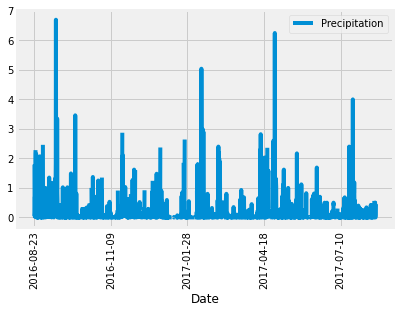

In [37]:
preci_df.sort_index().plot(rot=90)

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
preci_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [50]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(station.name).count()

print(F"There are {station_count} stations")

There are 9 stations


In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp = [func.max(measurement.tobs), 
       func.min(measurement.tobs), 
       func.avg(measurement.tobs)]

temp_data = session.query(*temp).\
    filter(measurement.station == 'USC00519281').all()
temp_data

[(85.0, 54.0, 71.66378066378067)]

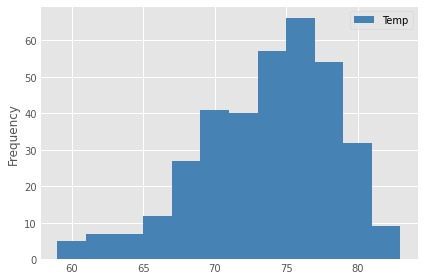

In [154]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(measurement.date).filter(measurement.station == "USC00519281").\
    order_by(measurement.date.desc()).first()

last_year = dt.date(2017, 8, 18) - dt.timedelta(days=365)

temperature = session.query(measurement.tobs).\
                filter(measurement.station == 'USC00519281').\
                filter(measurement.date >= last_year).all()
temp_df = pd.DataFrame(temperature, columns=['Temp'])
temp_df.plot.hist(bins=12,color='steelblue')
plt.tight_layout()